Cloning into 'Affordance3DHighlighter'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 244 (delta 1), reused 1 (delta 0), pack-reused 238 (from 1)
Receiving objects: 100% (244/244), 2.56 MiB | 5.84 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [2]:
import os

os.chdir('/content/Affordance3DHighlighter')

In [4]:
!pip install gdown
!gdown --id 1siZtGusB1LfQVapTvNOiYi8aeKKAgcDF
!unzip full-shape.zip -d /content/Affordance3DHighlighter/data/

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1siZtGusB1LfQVapTvNOiYi8aeKKAgcDF
From (redirected): https://drive.google.com/uc?id=1siZtGusB1LfQVapTvNOiYi8aeKKAgcDF&confirm=t&uuid=f9c8430e-db6d-4174-884d-d2051d5f2489
To: /content/Affordance3DHighlighter/full-shape.zip
100% 558M/558M [00:02<00:00, 248MB/s]
Archive:  full-shape.zip
  inflating: /content/Affordance3DHighlighter/data/full_shape_train_data.pkl  
  inflating: /content/Affordance3DHighlighter/data/full_shape_val_data.pkl  


In [ ]:
import pickle

# Load training data
with open('/kaggle/working/Affordance3DHighlighter/data/full_shape_train_data.pkl', 'rb') as train_file:
    train_data = pickle.load(train_file)
# Inspect the contents
print(f"Training Data Type: {type(train_data)}")
print(f"Training Data Example: {train_data[:1]}")

In [5]:
!pip install git+https://github.com/openai/CLIP.git
!pip install kaolin==0.17.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.5.1_cu121.html

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vy083w8w
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vy083w8w
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=1a11354961826648cb13017e78684c7659b8fce4edb9795af6db6b1eed5c3eaf
  Stored in directory: /tmp/pip-ephem-wheel-cache-cko9xu5a/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Looking in links: https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.5.1_cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━

In [ ]:

import sys
import torch

need_pytorch3d = False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d = True
if need_pytorch3d:
    pyt_version_str = torch.__version__.split("+")[0].replace(".", "")
    version_str = "".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".", ""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
!pip install open3d

In [ ]:
!mkdir -p data/PittsburghBridge
!wget -P data/PittsburghBridge https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz

In [8]:

from src.mesh import Mesh
from pytorch3d.structures import Pointclouds

from src.convertor import obj_to_pointcloud


def bounding_sphere_normalize(points: torch.Tensor) -> torch.Tensor:
    """
    points: (N,3) tensor of point coords
    Return normalized points in a unit sphere centered at origin.
    """
    center = points.mean(dim=0, keepdim=True)
    max_dist = (points - center).norm(p=2, dim=1).max()
    points_normed = (points - center) / max_dist
    return points_normed


def load_3d_data(file_path, num_points=10000, device="cuda", do_normalize=True):
    """
    Loads 3D data as PyTorch3D Pointclouds from either NPZ point cloud or OBJ mesh.

    Args:
        file_path: Path to either .npz point cloud or .obj mesh file
        num_points: Number of points to sample if loading from mesh
        device: Device to load data on

    Returns:
        Pointclouds object containing points and features
    """
    file_ext = file_path.split('.')[-1].lower()

    if file_ext == 'npz':
        # Load NPZ point cloud directly like in the example
        pointcloud = np.load(file_path)
        verts = torch.Tensor(pointcloud['verts']).to(device)
        rgb = torch.Tensor(pointcloud['rgb']).to(device)

        print("lenght of the data")
        print(len(verts))

        # Subsample if needed
        if len(verts) > num_points:
            idx = torch.randperm(len(verts))[:num_points]
            verts = verts[idx]
            rgb = rgb[idx]

        if do_normalize:
            verts = bounding_sphere_normalize(verts)

        # Return both the points tensor and the Pointclouds object
        point_cloud = Pointclouds(points=[verts], features=[rgb])
        return verts, point_cloud  # Return both

    elif file_ext == 'obj':
        # Load and convert your OBJ file
        points, point_cloud = obj_to_pointcloud(
            file_path,
            num_points=num_points,  # Adjust this number as needed
            device="cuda"  # Use "cpu" if you don't have a GPU
        )
        if do_normalize:
            points = bounding_sphere_normalize(points)
            # here we update the point cloud too
            rgb = point_cloud.features_packed() # shape [N,3]
            point_cloud = Pointclouds(points = [points], features = [rgb])
        return points, point_cloud
        # # Load mesh and sample points
        # mesh = Mesh(file_path)
        # vertices = mesh.vertices

        # # Sample random points
        # idx = torch.randperm(vertices.shape[0])[:num_points]
        # points = vertices[idx].to(device)

        # # Initialize with gray color
        # colors = torch.ones_like(points) * 0.7

        # return Pointclouds(points=[points], features=[colors])

    else:
        raise ValueError(f"Unsupported file format: {file_ext}. Only .npz and .obj are supported.")



Warp 1.5.1 initialized:
   CUDA Toolkit 12.6, Driver 12.2
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "Tesla T4" (15 GiB, sm_75, mempool enabled)
   Kernel cache:
     /root/.cache/warp/1.5.1


In [ ]:
def print_grad_fn(tensor, depth=0):
    """Recursively print the gradient function graph"""
    if tensor.grad_fn is None:
        print("  " * depth + "None (leaf tensor)")
        return

    print("  " * depth + str(tensor.grad_fn))
    for fn in tensor.grad_fn.next_functions:
        if fn[0] is not None:
            print("  " * (depth + 1) + str(fn[0]))

In [9]:

from src.render.cloud_point_renderer import MultiViewPointCloudRenderer
from src.save_results import save_renders, save_results
from src.neural_highlighter import NeuralHighlighter
from src.Clip.loss_function import clip_loss
from src.Clip.clip_model import get_clip_model, encode_text, setup_clip_transforms

import torch
import numpy as np
import random
from tqdm import tqdm

# Constrain most sources of randomness
# (some torch backwards functions within CLIP are non-determinstic)
# Set a consistent seed for reproducibility
seed = 0  # You can use any integer value
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


def optimize_point_cloud(points, clip_model, renderer, encoded_text, log_dir: str, **kwargs):
    num_iterations = kwargs.get('num_iterations', 1000)
    learning_rate = kwargs.get('learning_rate', 1e-4)
    depth = kwargs.get('depth', 5)
    width = kwargs.get('network_width', 256)
    n_views = kwargs.get("n_views", 4)
    n_augs = kwargs.get('n_augs', 1)
    clipavg = kwargs.get('clipavg', 'view')
    device = kwargs.get('device', 'cuda')

    # Initialize network and optimizer
    net = NeuralHighlighter(
        depth=depth,  # Number of hidden layers
        width=width,  # Width of each layer
        out_dim=2,  # Binary classification (highlight/no-highlight)
        input_dim=3,  # 3D coordinates (x,y,z)
        positional_encoding=False  # As recommended in the paper
    ).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Set up the transforms
    clip_transform, augment_transform = setup_clip_transforms()

    # Training loop
    for i in tqdm(range(num_iterations)):
        optimizer.zero_grad()

        # Predict highlight probabilities
        pred_class = net(points)

        # Create colors based on predictions
        highlight_color = torch.tensor([204 / 255, 1.0, 0.0]).to(device)
        base_color = torch.tensor([180 / 255, 180 / 255, 180 / 255]).to(device)

        colors = pred_class[:, 0:1] * highlight_color + pred_class[:, 1:2] * base_color

        # Create and render point cloud
        point_cloud = renderer.create_point_cloud(points, colors)
        rendered_images = renderer.render_all_views(point_cloud=point_cloud, n_views=n_views)
        # Convert dictionary of images to tensor
        rendered_tensor = []
        for name, img in rendered_images.items():
            rendered_tensor.append(img.to(device))
        rendered_tensor = torch.stack(rendered_tensor)

        #Convert rendered images to CLIP format
        rendered_images = rendered_tensor.permute(0, 3, 1, 2)  # [B, H, W, C] -> [B, C, H, W]
        #print(rendered_images.shape)

        # Calculate CLIP loss
        loss = clip_loss(
            rendered_images=rendered_images,
            encoded_text=encoded_text,
            clip_transform=clip_transform,
            augment_transform=augment_transform,
            clip_model=clip_model,
            n_augs=n_augs,
            clipavg=clipavg
        )
        #print("Loss computation graph:")
        #print_grad_fn(loss)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item():.4f}")
            save_renders(log_dir, i, rendered_images)

    return net


def main(input_path, object_name, highlight_region, **kwargs):
    """
    Main function for 3D highlighting with configurable parameters.

    Args:
        input_path: Path to input 3D file (mesh or point cloud)
        object_name: Name of the object for the prompt
        highlight_region: Region to highlight
        **kwargs: Optional parameters with defaults:
            n_views: Number of views to render (default: 5)
            n_aug: Number of augmentations (default: 5)
            clipavg: Method for CLIP averaging (default: "view")
            network_depth: Depth of neural network (default: 5)
            network_width: Width of neural layers (default: 256)
            learning_rate: Learning rate for optimization (default: 1e-4)
            num_iterations: Number of training iterations (default: 500)
            num_points: Number of points to sample (default: 10000)
            device: Device to run on (default: "cuda")
            output_dir: Directory for outputs (default: "./output")
    """
    # Extract parameters from kwargs with defaults
    n_views = kwargs.get("n_views", 4)
    num_points = kwargs.get("num_points", 10000)
    device = kwargs.get("device", "cuda")
    output_dir = kwargs.get("output_dir", "./output")
    do_normalize = kwargs.get("do_normalize", True)

    try:
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        # Load 3D data (either mesh or point cloud)
        print(f"Loading 3D data from {input_path}...")
        points, point_cloud = load_3d_data(input_path, num_points=num_points, device=device)
        print(f"Loaded {len(points)} points")

        # Setup CLIP model
        print("Setting up CLIP model...")
        clip_model, preprocess, resolution = get_clip_model()

        # Create and encode prompt
        prompt = f"A 3D render of a gray {object_name} with highlighted {highlight_region}"
        print(f"Using prompt: {prompt}")
        text_features = encode_text(clip_model, prompt, device)

        # Initialize renderer
        print("Setting up renderer...")
        renderer = MultiViewPointCloudRenderer(
            image_size=512,
            base_dist=30,  # Your default view distance
            base_elev=10,  # Your default elevation
            base_azim=0,  # Your default azimuth
            device=device
        )

        # Optimize point cloud highlighting
        print("Starting optimization...")
        net = optimize_point_cloud(
            points=points,
            renderer=renderer,
            clip_model=clip_model,
            encoded_text=text_features,
            log_dir=output_dir,
            **kwargs
        )

        # Save results
        print("Saving results...")
        save_results(
            net=net,
            points=points,
            n_views=n_views,
            prompt=prompt,
            output_dir=output_dir,
            renderer=renderer,
            device=device
        )

        print("Processing complete!")
        return net, points

    except Exception as e:
        print(f"Error in processing: {str(e)}")
        raise



In [ ]:
main(
    input_path="/kaggle/working/Affordance3DHighlighter/data/candle.obj",
    object_name="candle",
    highlight_region="head",
    n_views=4,
    n_augs=1,
    clipavg="view",
    network_depth=5,
    network_width=256,
    learning_rate=1e-4,
    num_iterations=500,
    num_points=100000,
    device="cuda",
    output_dir="./output"
)

### Evaluation for part 3

Ground truth visual representation

In [16]:
def save_ground_truth_results(data_entry, output_dir, renderer, device="cuda", n_views=4):
    """
    Saves visualization of ground truth affordance labels using existing save functions.
    Now with more contrasting colors for better visibility.

    Args:
        data_entry: Dataset entry containing point cloud and labels
        output_dir: Directory to save results
        renderer: Point cloud renderer
        device: Computing device
        n_views: Number of views to render
    """
    with torch.no_grad():
        points = data_entry["coords"]
        labels_dict = data_entry["labels_dict"]
        shape_class = data_entry["shape_class"]

        # Create ground truth directory
        gt_dir = os.path.join(output_dir, 'ground_truth')
        os.makedirs(gt_dir, exist_ok=True)

        # Define colors for different affordances
        affordance_colors = {
            'openable': torch.tensor([1.0, 0.0, 0.0]).to(device),  # bright red
            'pushable': torch.tensor([0.0, 0.0, 1.0]).to(device),  # bright blue
            'pull': torch.tensor([0.0, 1.0, 0.0]).to(device)       # bright green
        }

        # Darker base color for better contrast
        base_color = torch.tensor([0.3, 0.3, 0.3]).to(device)  # darker gray

        # Process each affordance
        for affordance, labels in labels_dict.items():
            # Convert labels to the same format as network predictions
            pred_class = torch.stack([1 - labels, labels], dim=1)

            # Use the corresponding color for this affordance
            highlight_color = affordance_colors.get(affordance, torch.tensor([1.0, 0.0, 0.0]).to(device))  # default to red
            colors = pred_class[:, 1:2] * highlight_color + pred_class[:, 0:1] * base_color

            # Save raw point cloud data using existing function
            save_point_cloud_results(
                points=points,
                colors=colors,
                output_path=os.path.join(gt_dir, f'gt_pointcloud_{affordance}.ply')
            )

            # Create and render point cloud
            point_cloud = renderer.create_point_cloud(points, colors)
            rendered_images = renderer.render_all_views(point_cloud=point_cloud, n_views=n_views)

            # Convert dictionary of images to tensor
            rendered_tensor = []
            for name, img in rendered_images.items():
                rendered_tensor.append(img.to(device))
            rendered_tensor = torch.stack(rendered_tensor)

            # Convert rendered images to proper format
            rendered_images = rendered_tensor.permute(0, 3, 1, 2)  # [B, H, W, C] -> [B, C, H, W]
            rendered_images = (rendered_images * 255).clamp(0, 255).to(torch.uint8)

            # Save rendered images using existing function
            save_renders(
                dir=gt_dir,
                i=0,
                rendered_images=rendered_images.float() / 255.0,
                name=f'gt_render_{affordance}.png'
            )

            # Save metadata
            with open(os.path.join(gt_dir, f'gt_info_{affordance}.txt'), 'w') as f:
                f.write(f"Shape Class: {shape_class}\n")
                f.write(f"Affordance: {affordance}\n")
                f.write(f"Positive labels: {labels.sum().item()}/{len(labels)}")

### Part 3
Hyperparam + Strategy Tuning, Then Test Evaluation
Teammates focus on the below code block for the reporting part of part 3.

In [22]:
from src.prompt_strategies import generate_affordance_prompt

def train_and_evaluate_shape(
    shape_entry, # single shape (object) is passed, a dictionary containing point cloud coordinates, class, affordance
    clip_model, # pre trained clip model
    strategy, # prompt strategy, e.g basic, affordance class specific
    threshold, # binary classification threshold for highlighting. As we know highlighting (or the contrast of highlighting
    # is done on the basis of probability distribution generated. so closer the value to 1 the brighter it is. so threshold filters out noise which helps miou)
    device="cuda",
    num_iterations=200 # Number of optimization steps.
):
    """
    Trains and evaluates a neural highlighter for a single 3D shape.
    Process:
    1. Creates fresh neural network
    2. Generates prompt using shape's first affordance and selected strategy
    3. Trains network for specified iterations
    4. Evaluates IoU across ALL affordances using given threshold
    5. Returns average IoU for this shape
    """
    # Extracts shape data from dictionary
    shape_coords = shape_entry["coords"] # point cloud coordinates
    shape_class = shape_entry["shape_class"] # object class (e.g "DOOR")
    affs = shape_entry["affordances"] # List of affordances (e.g., ["Openable", "Pushable"])
    label_dict = shape_entry["labels_dict"] # Ground truth labels for each affordance

    # Make sure coords is on GPU
    if not isinstance(shape_coords, torch.Tensor):
        shape_coords = torch.tensor(shape_coords, device=device)



    # We initialize fresh neural network for this shape
    # change in order to observe better results.
    net = NeuralHighlighter(depth=5, width=256, out_dim=2, input_dim=3).to(device)

    # Here we fetch the first affordance in the class
    main_aff = affs[0]  # e.g "open" for door

    # Here we generate the affordance and class specific prompt!
    prompt_str = generate_affordance_prompt(shape_class, main_aff, strategy)
    # here the prompt is converted to text features.
    text_feats = encode_text(clip_model, prompt_str, device=device)

    # Point cloud renderer is initialized here
    # These parameters can also be changed in order to achieve the configuration!
    renderer = MultiViewPointCloudRenderer(
        image_size=256, base_dist=20, base_elev=10, device=device
    )

    # Train network through optimization
    # Clip is used here to align rendered views with text prompt
    net = optimize_point_cloud(
        points=shape_coords,
        clip_model=clip_model,
        renderer=renderer,
        encoded_text=text_feats,
        log_dir="./val_tmp",
        num_iterations=num_iterations,
        device=device,
        n_views=2 # this can be changed to test different config.
    )

    # Evaluate IoU across all affordances
    with torch.no_grad():
        pred_class = net(shape_coords)  # shape [N,2]
        highlight_scores = pred_class[:,0] # get highlighting probability

    # here we calculate average iou (mIoU) across all affordances of a shape. so one door with three diff affordances.
    shape_sum = 0.0
    c = 0
    for aff in affs:
        # convert ground truth to binary for comparison
        gt_bin = (label_dict[aff]>0.0).long()
        # here we convert predictions to binary using threshold
        bin_pred = (highlight_scores >= threshold).long()
        # compute IoU for this affordance
        iou_val = compute_mIoU(bin_pred, gt_bin)
        shape_sum += iou_val
        c += 1

    # Here we return the mean iou accross all affordances
    shape_mean = shape_sum/c if c>0 else 0.0
    return shape_mean


def grid_search_validation(
    val_dataset, # validation set
    clip_model, # clip model
    device='cuda', # computation device
    strategies=('basic','affordance_specific'), # strategies
    thresholds=(0.3, 0.5, 0.7), # classification threshold to try
    num_val_objects=3, # number of validation objects to use
    num_iterations=200, # the number of iterations
    output_dir="./val_gridsearch"
):
    """
    For each (strategy, threshold), pick up to 'num_val_objects' shapes from val_dataset,
    train & evaluate each shape => average IoU => pick best combo.
    """
    import random

    os.makedirs(output_dir, exist_ok=True)
    val_indices = list(range(min(num_val_objects, len(val_dataset))))

    # We'll pick 'num_val_objects' shapes from the val dataset for speed
    val_indices = list(range(min(num_val_objects, len(val_dataset))))
    best_strategy = None
    best_threshold = None
    best_iou = -1.0
    all_results = []

    print("[grid_search_validation] Starting shape-by-shape training on validation, with saving GT & predictions...")

    for strategy in strategies:
        for th in thresholds:
            print(f"\n=== Trying strategy='{strategy}', threshold={th} ===")
            sum_iou = 0.0
            count = 0

            combo_dir = os.path.join(output_dir, f"val_{strategy}_th{th}")
            os.makedirs(combo_dir, exist_ok=True)

            # For each shape in val_indices
            for i, idx in enumerate(val_indices):
                shape_entry = val_dataset[idx]
                shape_id = shape_entry.get('shape_id', f'valshape_{idx}')
                shape_class = shape_entry["shape_class"]
                affs = shape_entry["affordances"]
                label_dict = shape_entry["labels_dict"]

                shape_coords = shape_entry["coords"]
                if not isinstance(shape_coords, torch.Tensor):
                    shape_coords = torch.tensor(shape_coords, device=device)

                shape_subdir = os.path.join(combo_dir, f"val_shape_{shape_id}")
                os.makedirs(shape_subdir, exist_ok=True)
                os.makedirs(os.path.join(shape_subdir, "predictions"), exist_ok=True)

                print(f"  -> [Shape {i+1}/{len(val_indices)}] ID={shape_id}, Class={shape_class}, Affs={affs}")

                try:
                    # 1) Save ground truth
                    renderer = MultiViewPointCloudRenderer(
                        image_size=256, base_dist=20, base_elev=10, device=device
                    )
                    save_ground_truth_results(
                        data_entry=shape_entry,
                        output_dir=shape_subdir,
                        renderer=renderer,
                        device=device,
                        n_views=4
                    )

                    # 2) Train net
                    net = NeuralHighlighter(depth=5, width=256, out_dim=2, input_dim=3).to(device)
                    main_aff = affs[0]  # first affordance
                    prompt_str = generate_affordance_prompt(shape_class, main_aff, strategy)

                    from src.Clip.clip_model import encode_text
                    text_feats = encode_text(clip_model, prompt_str, device=device)

                    net = optimize_point_cloud(
                        points=shape_coords,
                        clip_model=clip_model,
                        renderer=renderer,
                        encoded_text=text_feats,
                        log_dir=os.path.join(shape_subdir, "optimization_logs"),
                        num_iterations=num_iterations,
                        device=device,
                        n_views=4
                    )

                    # 3) Save predictions
                    save_results(
                        net=net,
                        points=shape_coords,
                        prompt=prompt_str,
                        output_dir=os.path.join(shape_subdir, "predictions"),
                        renderer=renderer,
                        device=device,
                        n_views=4
                    )

                    # 4) measure IoU across all affs
                    with torch.no_grad():
                        pred_class = net(shape_coords)  # shape [N,2]
                        highlight_scores = pred_class[:,0]

                    shape_sum=0.0
                    c2=0
                    for aff in affs:
                        gt_bin = (label_dict[aff]>0.5).long()
                        bin_pred = (highlight_scores>= th).long()
                        iou_val = compute_mIoU(bin_pred, gt_bin)
                        shape_sum+= iou_val
                        c2+=1

                    shape_mean= shape_sum/c2 if c2>0 else 0.0
                    sum_iou += shape_mean
                    count += 1

                    # Write shape metrics
                    with open(os.path.join(shape_subdir, "metrics.txt"), 'w') as f:
                        f.write(f"Validation shape ID: {shape_id}\n")
                        f.write(f"Strategy: {strategy}\n")
                        f.write(f"Threshold: {th}\n")
                        f.write(f"Mean IoU: {shape_mean:.3f}\n")

                    print(f"     shape IoU => {shape_mean:.3f}")

                except Exception as e:
                    print(f"[Warning] Skipped shape idx={idx} due to error: {e}")
                    continue

            # After finishing these shapes for this combo...
            avg_iou = sum_iou / count if count>0 else 0.0
            all_results.append((strategy, th, avg_iou))
            print(f"\n>>> Combo (strategy={strategy}, threshold={th}) => Mean IoU={avg_iou:.3f} over {count} shapes")

            # track best
            if avg_iou>best_iou:
                best_iou= avg_iou
                best_strategy= strategy
                best_threshold= th

    print("\n[grid_search_validation] Validation combos sorted by best IoU:")
    sorted_res= sorted(all_results, key=lambda x: x[2], reverse=True)
    for (s,t,iou) in sorted_res:
        print(f"    Strategy={s}, Threshold={t}, IoU={iou:.3f}")

    print(f"\n[grid_search_validation] Best strategy={best_strategy}, threshold={best_threshold}, average mIoU={best_iou:.3f}")
    return best_strategy, best_threshold, best_iou


def test_phase_evaluation(
    test_dataset,
    clip_model,
    best_strategy,
    best_threshold,
    device='cuda',
    num_test_shapes=3,
    num_iterations=200,
    output_dir="./test_results"  # Added output directory parameter
):
    """
    Evaluate the pipeline on test dataset and save both ground truth and prediction visualizations.
    Returns the final average test IoU.
    """
    import os
    import random

    test_indices = list(range(min(num_test_shapes, len(test_dataset))))
    sum_test_iou = 0.0
    c = 0

    print(f"[test_phase_evaluation] Using strategy={best_strategy}, threshold={best_threshold}")

    for idx in test_indices:
        shape_entry = test_dataset[idx]
        shape_id = shape_entry.get('shape_id', f'shape_{idx}')

        # Create directory for this test shape
        shape_dir = os.path.join(output_dir, f"test_shape_{shape_id}")
      # ensure all subdirs
        os.makedirs(shape_dir, exist_ok=True)
        os.makedirs(os.path.join(shape_dir,"predictions"), exist_ok=True)


        try:
            # Initialize renderer
            renderer = MultiViewPointCloudRenderer(
                image_size=256, base_dist=20, base_elev=10, device=device
            )

            # 1. Save ground truth visualization
            save_ground_truth_results(
                data_entry=shape_entry,
                output_dir=shape_dir,
                renderer=renderer,
                device=device,
                n_views=4
            )

            # 2. Train and evaluate network
            net = NeuralHighlighter(depth=5, width=256, out_dim=2, input_dim=3).to(device)

            # Generate prompt and encode text
            main_aff = shape_entry["affordances"][0]
            prompt_str = generate_affordance_prompt(shape_entry["shape_class"], main_aff, best_strategy)
            text_feats = encode_text(clip_model, prompt_str, device=device)

            # Train network
            net = optimize_point_cloud(
                points=shape_entry["coords"],
                clip_model=clip_model,
                renderer=renderer,
                encoded_text=text_feats,
                log_dir=os.path.join(shape_dir, "optimization_logs"),
                num_iterations=num_iterations,
                device=device,
                n_views=4
            )

            # 3. Save network predictions
            save_results(
                net=net,
                points=shape_entry["coords"],
                prompt=prompt_str,
                output_dir=os.path.join(shape_dir, "predictions"),
                renderer=renderer,
                device=device,
                n_views=4
            )

            # 4. Compute and save metrics
            with torch.no_grad():
                pred_class = net(shape_entry["coords"])
                highlight_scores = pred_class[:,0]

            shape_sum = 0.0
            affordance_ious = {}
            for aff in shape_entry["affordances"]:
                gt_bin = (shape_entry["labels_dict"][aff] > 0.0).long()
                bin_pred = (highlight_scores >= best_threshold).long()
                iou_val = compute_mIoU(bin_pred, gt_bin)
                affordance_ious[aff] = iou_val
                shape_sum += iou_val

            shape_mean = shape_sum / len(shape_entry["affordances"])
            sum_test_iou += shape_mean
            c += 1

            # Save metrics
            with open(os.path.join(shape_dir, "metrics.txt"), 'w') as f:
                f.write(f"Shape ID: {shape_id}\n")
                f.write(f"Class: {shape_entry['shape_class']}\n")
                f.write(f"Strategy: {best_strategy}\n")
                f.write(f"Threshold: {best_threshold}\n")
                f.write(f"Mean IoU: {shape_mean:.3f}\n\n")
                f.write("Per-affordance IoUs:\n")
                for aff, iou in affordance_ious.items():
                    f.write(f"{aff}: {iou:.3f}\n")

            print(f"  -> shape idx={idx}, shape mean IoU={shape_mean:.3f}")

        except Exception as e:
            print(f"  [Warning] Skipped shape idx={idx} due to error: {e}")
            continue

    final_test_iou = sum_test_iou/c if c>0 else 0.0
    print(f"[test_phase_evaluation] Final mIoU = {final_test_iou:.3f} (over {c} shapes)")

    # Save overall test results
    with open(os.path.join(output_dir, "test_summary.txt"), 'w') as f:
        f.write(f"Test Summary\n")
        f.write(f"============\n")
        f.write(f"Number of shapes tested: {c}\n")
        f.write(f"Best strategy: {best_strategy}\n")
        f.write(f"Best threshold: {best_threshold}\n")
        f.write(f"Final mIoU: {final_test_iou:.3f}\n")

    return final_test_iou


def compute_mIoU(pred_labels, gt_labels):
    intersection = ((pred_labels == 1) & (gt_labels == 1)).sum().float()
    union = ((pred_labels == 1) | (gt_labels == 1)).sum().float()
    if union == 0:
        return 0.0
    return (intersection / union).item()

## Here we pass different strategies and threshold values.

Found 107 valid door objects with all affordances
[Main] val_data size=10, test_data size=10
[grid_search_validation] Starting shape-by-shape training on validation, with saving GT & predictions...

=== Trying strategy='basic', threshold=0.3 ===
  -> [Shape 1/3] ID=f649133ee152f0c4535dab46efb28e27, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:36,  5.42it/s]

Iteration 0, Loss: -0.2249


 51%|█████     | 102/200 [00:17<00:15,  6.32it/s]

Iteration 100, Loss: -0.2390


100%|██████████| 200/200 [00:32<00:00,  6.19it/s]


     shape IoU => 0.031
  -> [Shape 2/3] ID=ca55384f8d7b2beaa0af12c1cf92de5f, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:30,  6.45it/s]

Iteration 0, Loss: -0.2284


 51%|█████     | 102/200 [00:15<00:15,  6.49it/s]

Iteration 100, Loss: -0.2332


100%|██████████| 200/200 [00:31<00:00,  6.27it/s]


     shape IoU => 0.000
  -> [Shape 3/3] ID=157d99a639b9b9aa5dd29c13c4b9a983, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:30,  6.51it/s]

Iteration 0, Loss: -0.1986


 51%|█████     | 102/200 [00:16<00:16,  5.96it/s]

Iteration 100, Loss: -0.2015


100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


     shape IoU => 0.001

>>> Combo (strategy=basic, threshold=0.3) => Mean IoU=0.010 over 3 shapes

=== Trying strategy='basic', threshold=0.5 ===
  -> [Shape 1/3] ID=f649133ee152f0c4535dab46efb28e27, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:31,  6.29it/s]

Iteration 0, Loss: -0.2308


 51%|█████     | 102/200 [00:16<00:15,  6.20it/s]

Iteration 100, Loss: -0.1964


100%|██████████| 200/200 [00:32<00:00,  6.21it/s]


     shape IoU => 0.000
  -> [Shape 2/3] ID=ca55384f8d7b2beaa0af12c1cf92de5f, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:32,  6.14it/s]

Iteration 0, Loss: -0.2356


 51%|█████     | 102/200 [00:16<00:16,  5.90it/s]

Iteration 100, Loss: -0.2097


100%|██████████| 200/200 [00:32<00:00,  6.20it/s]


     shape IoU => 0.000
  -> [Shape 3/3] ID=157d99a639b9b9aa5dd29c13c4b9a983, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:32,  6.04it/s]

Iteration 0, Loss: -0.2183


 51%|█████     | 102/200 [00:16<00:15,  6.34it/s]

Iteration 100, Loss: -0.2028


100%|██████████| 200/200 [00:31<00:00,  6.27it/s]


     shape IoU => 0.060

>>> Combo (strategy=basic, threshold=0.5) => Mean IoU=0.020 over 3 shapes

=== Trying strategy='affordance_specific', threshold=0.3 ===
  -> [Shape 1/3] ID=f649133ee152f0c4535dab46efb28e27, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:31,  6.31it/s]

Iteration 0, Loss: -0.1960


 51%|█████     | 102/200 [00:16<00:16,  5.87it/s]

Iteration 100, Loss: -0.1925


100%|██████████| 200/200 [00:32<00:00,  6.21it/s]


     shape IoU => 0.000
  -> [Shape 2/3] ID=ca55384f8d7b2beaa0af12c1cf92de5f, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:31,  6.23it/s]

Iteration 0, Loss: -0.1998


 51%|█████     | 102/200 [00:16<00:15,  6.27it/s]

Iteration 100, Loss: -0.2236


100%|██████████| 200/200 [00:31<00:00,  6.27it/s]


     shape IoU => 0.000
  -> [Shape 3/3] ID=157d99a639b9b9aa5dd29c13c4b9a983, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:31,  6.35it/s]

Iteration 0, Loss: -0.1802


 51%|█████     | 102/200 [00:16<00:16,  5.80it/s]

Iteration 100, Loss: -0.2107


100%|██████████| 200/200 [00:32<00:00,  6.22it/s]


     shape IoU => 0.000

>>> Combo (strategy=affordance_specific, threshold=0.3) => Mean IoU=0.000 over 3 shapes

=== Trying strategy='affordance_specific', threshold=0.5 ===
  -> [Shape 1/3] ID=f649133ee152f0c4535dab46efb28e27, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:31,  6.29it/s]

Iteration 0, Loss: -0.1766


 51%|█████     | 102/200 [00:16<00:15,  6.29it/s]

Iteration 100, Loss: -0.1984


100%|██████████| 200/200 [00:31<00:00,  6.27it/s]


     shape IoU => 0.000
  -> [Shape 2/3] ID=ca55384f8d7b2beaa0af12c1cf92de5f, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:31,  6.34it/s]

Iteration 0, Loss: -0.1995


 51%|█████     | 102/200 [00:16<00:16,  5.89it/s]

Iteration 100, Loss: -0.2222


100%|██████████| 200/200 [00:32<00:00,  6.23it/s]


     shape IoU => 0.000
  -> [Shape 3/3] ID=157d99a639b9b9aa5dd29c13c4b9a983, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:31,  6.34it/s]

Iteration 0, Loss: -0.2040


 51%|█████     | 102/200 [00:16<00:15,  6.30it/s]

Iteration 100, Loss: -0.2086


100%|██████████| 200/200 [00:31<00:00,  6.28it/s]


     shape IoU => 0.000

>>> Combo (strategy=affordance_specific, threshold=0.5) => Mean IoU=0.000 over 3 shapes

[grid_search_validation] Validation combos sorted by best IoU:
    Strategy=basic, Threshold=0.5, IoU=0.020
    Strategy=basic, Threshold=0.3, IoU=0.010
    Strategy=affordance_specific, Threshold=0.3, IoU=0.000
    Strategy=affordance_specific, Threshold=0.5, IoU=0.000

[grid_search_validation] Best strategy=basic, threshold=0.5, average mIoU=0.020

[Main] Validation done => best strategy=basic, threshold=0.5, valIoU=0.020
[test_phase_evaluation] Using strategy=basic, threshold=0.5


  1%|          | 2/200 [00:00<00:33,  5.89it/s]

Iteration 0, Loss: -0.2341


 51%|█████     | 102/200 [00:16<00:15,  6.17it/s]

Iteration 100, Loss: -0.2323


100%|██████████| 200/200 [00:32<00:00,  6.23it/s]


  -> shape idx=0, shape mean IoU=0.087


  1%|          | 2/200 [00:00<00:31,  6.31it/s]

Iteration 0, Loss: -0.2290


 51%|█████     | 102/200 [00:16<00:15,  6.22it/s]

Iteration 100, Loss: -0.2311


100%|██████████| 200/200 [00:31<00:00,  6.26it/s]


  -> shape idx=1, shape mean IoU=0.000


  1%|          | 2/200 [00:00<00:32,  6.00it/s]

Iteration 0, Loss: -0.2433


 51%|█████     | 102/200 [00:16<00:15,  6.26it/s]

Iteration 100, Loss: -0.2678


100%|██████████| 200/200 [00:32<00:00,  6.22it/s]


  -> shape idx=2, shape mean IoU=0.000
[test_phase_evaluation] Final mIoU = 0.029 (over 3 shapes)
[Main] Final test IoU => 0.029

[Main] Visualizing multi-view for the last test shape...


  1%|          | 2/200 [00:00<00:16, 11.67it/s]

Iteration 0, Loss: -0.2477


 52%|█████▏    | 103/200 [00:09<00:08, 10.78it/s]

Iteration 100, Loss: -0.2495


  1%|          | 2/200 [00:00<00:16, 11.81it/s]

Iteration 0, Loss: -0.2261


 51%|█████     | 102/200 [00:09<00:08, 11.59it/s]

Iteration 100, Loss: -0.2324


100%|██████████| 200/200 [00:18<00:00, 11.08it/s]


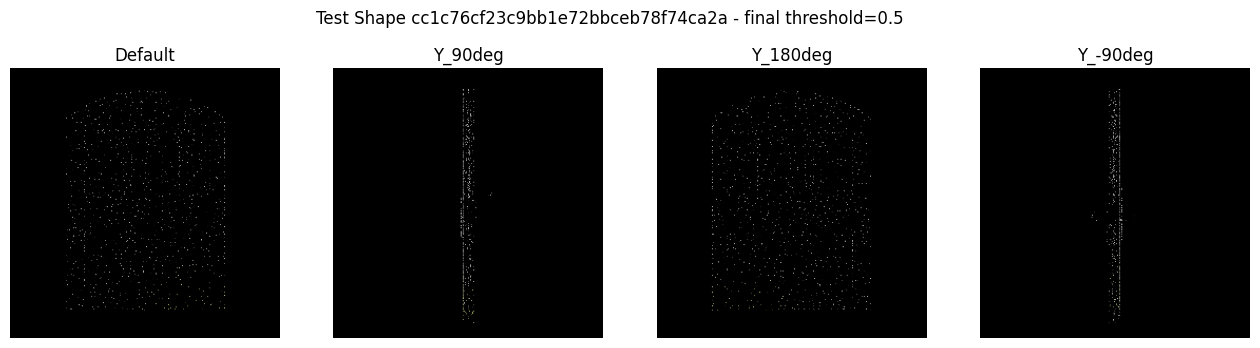

In [23]:
import torch
import matplotlib.pyplot as plt

# 1) Imports from your code
from src.data_loader_fullshape import create_dataset_splits, FullShapeDataset
from src.prompt_strategies import generate_affordance_prompt
from src.Clip.clip_model import get_clip_model
from src.render.cloud_point_renderer import MultiViewPointCloudRenderer
from src.neural_highlighter import NeuralHighlighter


device = "cuda"

dataset = FullShapeDataset("/content/Affordance3DHighlighter/data/full_shape_train_data.pkl", device=device)
train_data, val_data, test_data = create_dataset_splits(dataset, val_ratio=0.1, test_ratio=0.1)


print(f"[Main] val_data size={len(val_data)}, test_data size={len(test_data)}")

# 3) Load CLIP model
clip_model, _, _ = get_clip_model("ViT-L/14")

# 4) Validation Phase: search best (strategy, threshold)
strategies_list = ["basic", "affordance_specific"]
thresholds_list = [0.3, 0.5]  # let's have 2 thresholds now
num_val_objects = 3          # how many shapes we pick from val
num_iterations_val = 200     # how many training steps

best_strat, best_th, best_val_iou = grid_search_validation(
    val_dataset=val_data,
    clip_model=clip_model,
    device=device,
    strategies=strategies_list,
    thresholds=thresholds_list,
    num_val_objects=num_val_objects,
    num_iterations=num_iterations_val,
    output_dir="./val_gridsearch"
)

print(f"\n[Main] Validation done => best strategy={best_strat}, threshold={best_th}, valIoU={best_val_iou:.3f}")

# 5) Test Phase
num_test_shapes = 3
test_iterations = 200
final_test_iou = test_phase_evaluation(
    test_dataset=test_data,
    clip_model=clip_model,
    best_strategy=best_strat,
    best_threshold=best_th,
    device=device,
    num_test_shapes=num_test_shapes,
    num_iterations=test_iterations,
    output_dir="./test_results"
)
print(f"[Main] Final test IoU => {final_test_iou:.3f}")

# 6) (Optional) Visualize multi-view for the last test shape
if len(test_data)>0:
    last_idx = min(num_test_shapes, len(test_data)) - 1
    last_shape = test_data[last_idx]
    print("\n[Main] Visualizing multi-view for the last test shape...")

    # We'll do a quick training again
    shape_mean = train_and_evaluate_shape(
        last_shape,
        clip_model,
        best_strat,
        best_th,
        device=device,
        num_iterations=test_iterations
    )
    # Now we do a manual multi-view color-labeled scatter
    coords_test = last_shape["coords"]
    if not isinstance(coords_test, torch.Tensor):
        coords_test = torch.tensor(coords_test, device=device)

    # We can re-run the net
    net = NeuralHighlighter(depth=5, width=256, out_dim=2, input_dim=3).to(device)
    from src.Clip.clip_model import encode_text
    aff_main = last_shape["affordances"][0]
    prompt_main = generate_affordance_prompt(last_shape["shape_class"], aff_main, best_strat)
    txt_main = encode_text(clip_model, prompt_main, device=device)
    renderer = MultiViewPointCloudRenderer(image_size=256, base_dist=20, base_elev=10, device=device)
    net = optimize_point_cloud(
        points=coords_test,
        clip_model=clip_model,
        renderer=renderer,
        encoded_text=txt_main,
        log_dir="./test_vis",
        num_iterations=test_iterations,
        device=device,
        n_views=2
    )

    with torch.no_grad():
        pred_ = net(coords_test)[:,0]

    # color
    color_tensor = pred_.unsqueeze(1)*torch.tensor([204/255,1.0,0.0], device=device) + (1.0 - pred_.unsqueeze(1))*torch.tensor([180/255,180/255,180/255], device=device)
    point_cloud = renderer.create_point_cloud(coords_test, color_tensor)
    rendered_dict = renderer.render_all_views(point_cloud, n_views=4)

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, len(rendered_dict), figsize=(4*len(rendered_dict), 4))
    for ax, (vname, imgT) in zip(axes, rendered_dict.items()):
        ax.imshow(imgT.cpu().numpy())
        ax.set_title(vname)
        ax.axis('off')
    plt.suptitle(f"Test Shape {last_shape['shape_id']} - final threshold={best_th}")
    plt.show()
